# Getting Started with MLFlow: an end-to-end example

This tutorial covers the following steps:
- Mlflow Installation
- MlFlow Tracking
    - Auto Tracking with Sklearn
    - Auto Tracking with Sklearn (Hyper-parameter Tuning Usecase)
    - Manual Tracking
- MlFlow Model 
    - Model Logging
    - Model Validation
- MlFlow Model Registry
    - Model Registration and versioning
    - Model Serving
    - Model Serving Validation

In this example, you will build a RandomForest Regressor to predict the disease progression of diabetes in patients based on the patient's biological markers using data from sklearn.datasets

## Requirements
This notebook requires these libraries:
- sklearn 
- pandas

To install, run `pip install sklearn,pandas` command in CMD or Anaconda Prompt. 

## MLFlow Installation

There are three main methods of installation namely:
- **Local Installation**: MLflow can be installed locally via pip or conda the package manager for Python. To install MLflow using pip, you can run the following command in your terminal: `pip install mlflow` Or, if you are using conda, run the following command in your terminal: `conda install -c conda-forge mlflow` 
- **Docker Installation**: MLflow can also be installed via Docker, a popular platform for building and running containers. To install MLflow using Docker, you can pull the MLflow image from the Docker Hub and run it in a container.
- **Local or Remote Server Installation**: MLflow can also be installed on a local or remote server, allowing you to run experiments and log information on a shared environment. To install MLflow on a server, you can follow the same steps as the Pip Installation but on a remote server. This is typically used in an enterprise environment where you have different people working on the same project.

For this tutorial, we would be installing locally with the following steps:
- Open Anaconda prompt or CMD
- Run the below command on your terminal
    - Linux/ Mac Users
        - `pip install mlflow` if using pip or `conda install -c conda-forge mlflow` if using conda on your terminal
    - Windows Users
        - `pip uninstall waitress,Flask,mlflow`
        - `pip install waitress,Flask,mlflow[extra]`
        
## MLFlow UI

By default, wherever you run your program, the tracking API writes data into files into a local ./mlruns directory. You can then run MLflow’s Tracking UI in anacaonda prompt or CMD terminal: `mlflow ui` and view it at http://localhost:5000. 


## MLFlow Tracking
You can track an experiment using the MLFlow API.

#### Import the required libraries

In [42]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import pandas as pd
import matplotlib.pyplot as plt
import os
 
from numpy import savetxt
 
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import logging

logging.getLogger("mlflow").setLevel(logging.ERROR)

# mlflow.set_tracking_uri("http://localhost:5000")

#### Import Data

In [37]:
db = load_diabetes()
X = db.data
y = db.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Auto Tracking with Sklearn

The code snippet below invokes the autolog() from sklearn and sets and experiment name (This can be changed) and a run name. By default, a different run id is automatically generated for each run. A RandomForestRegressor is trained and the autolog method tracks all relevant parameters,metrics,artifacts and model into MLflow. Once executed, go to MLFlow UI and view the new experiment and run. 

In [39]:
# Enable autolog()
mlflow.sklearn.autolog()
 
# With autolog() enabled, all model parameters, a model score, and the fitted model are automatically logged.  
mlflow.set_experiment('Diabetes Prediction') 
with mlflow.start_run(run_name = 'Baseline Model'):

    # Set the model parameters. 
    n_estimators = 100
    max_depth = 6
    max_features = 3

    for x in range(1,5):
    # Create and train model.
        rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)
        rf.fit(X_train, y_train)

        # Use the model to make predictions on the test dataset.
        predictions = rf.predict(X_test)

### Auto Tracking with Sklearn (Hyperparameter Tuning Use Case)

MLFlow Tracking can be used to track and compare the results of the different runs in hyperparameter tunning. Execute the code snippet below and view on the MLFlow UI. 

**NB**: We didn't have to set experiment name because once the parameter is set, it is used throughout the session until it's changed

In [40]:
# Enable autolog()
mlflow.sklearn.autolog()

# mlflow.set_experiment('Solar Flare Prediction')
 
# Set the model parameters. 
n_estimators = [10,20,30,40,50,100]
max_depth = [3,4,5,6,7,10]
max_features = [3,4,5,6,7,10]

for x in range(1,5):
    
    with mlflow.start_run(run_name = f'Hyperparameter Tuning - {x}'):
        
        # Create and train model.
        rf = RandomForestRegressor(n_estimators = n_estimators[x], max_depth = max_depth[x], max_features = max_features[x])
        rf.fit(X_train, y_train)

        # Use the model to make predictions on the test dataset.
        predictions = rf.predict(X_test)

### Manual Logging

In scenarios where you dont want to track all the metrics or want to track custom metrics,parameters or artifacts, you can manually track the specifics parameters.

Run ID: 0bdefc54dccb4cbc9e3874ddb1374226
<RunInfo: artifact_uri='file:///C:/Users/mraji855/Documents/Mlflow/Experiments/mlruns/654934164191656106/0bdefc54dccb4cbc9e3874ddb1374226/artifacts', end_time=None, experiment_id='654934164191656106', lifecycle_stage='active', run_id='0bdefc54dccb4cbc9e3874ddb1374226', run_name='Baseline', run_uuid='0bdefc54dccb4cbc9e3874ddb1374226', start_time=1675214841193, status='RUNNING', user_id='mraji855'>


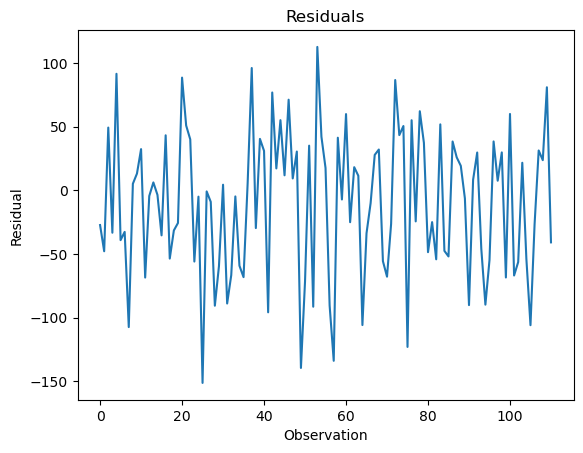

In [56]:
mlflow.set_experiment('Coronal Mass Ejections')
with mlflow.start_run(run_name = 'Baseline'):
  
    # Set the model parameters. 
    n_estimators = 100
    max_depth = 6
    max_features = 3

    # Create and train model.
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)
    rf.fit(X_train, y_train)

    # Use the model to make predictions on the test dataset.
    predictions = rf.predict(X_test)

    # Log the model parameters used for this run.
    mlflow.log_param("num_trees", n_estimators)
    mlflow.log_param("maxdepth", max_depth)
    mlflow.log_param("max_feat", max_features)

    # Define a metric to use to evaluate the model.
    mse = mean_squared_error(y_test, predictions)

    # Log the value of the metric from this run.
    mlflow.log_metric("mse", mse)

    # Include Model Signature
    signature = infer_signature(X_train,rf.predict(X_test))

    # Log the model created by this run.
    mlflow.sklearn.log_model(rf, "random-forest-model",signature=signature) 

    # Save the table of predicted values
    savetxt('predictions.csv', predictions, delimiter=',')

    # Log the saved table as an artifact
    mlflow.log_artifact("predictions.csv")

    # Convert the residuals to a pandas dataframe to take advantage of graphics capabilities
    df = pd.DataFrame(data = predictions - y_test)

    # Create a plot of residuals
    plt.plot(df)
    plt.xlabel("Observation")
    plt.ylabel("Residual")
    plt.title("Residuals")

    # Save the plot and log it as an artifact

    plt.savefig("residuals_plot.png")
    mlflow.log_artifact("residuals_plot.png") 
    print(f"Run ID: {mlflow.active_run().info.run_id}")
    # mlflow.log_artifact(os.path.abspath(__file__), 'source code')
    # print(f"artifact_uri={mlflow.get_artifact_uri()}")

## MLFlow Model
An MLflow Model is a standard format for packaging machine learning models that can be used in a variety of downstream tools—for example, real-time serving through a REST API or batch inference on Apache Spark. The format defines a convention that lets you save a model in different “flavors” that can be understood by different downstream tools.

In the last code snippet, we logged the ML model with the command `mlflow.sklearn.log_model(rf, "random-forest-model",signature=signature)`. The signature argument allows us to include a schema with the model.

### Model Validation

In [51]:
import mlflow
run_id = '<insert Run ID>'
logged_model = f'runs:/{run_id}/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(X_test))

array([232.80267925, 107.16602723, 150.42200503, 166.78505678,
       146.35945277, 162.89522993, 189.57968811, 213.40199944,
       165.57920397, 152.52366334,  84.5924348 , 233.54295836,
        88.07144955, 228.71436782,  86.77882565, 243.14520977,
       123.63145984, 145.75338316, 217.55724843, 198.50413266,
       213.74841651, 168.86859689, 100.05350664, 213.53473092,
       139.04751222, 169.21961303, 176.88059653, 117.88794385,
        89.66125726, 234.3578485 , 203.00553247, 121.26228823,
       189.20417248, 273.65160034,  92.30992294, 198.7322544 ,
       193.8060252 , 142.35480657, 164.45712764, 115.78580534,
       213.15151327, 198.72086521, 188.48962457,  90.14169796,
       108.48851996,  87.07579023, 103.82376336, 107.71762063,
       100.45221122, 203.10703841, 107.24448965,  90.02848228,
       117.48509291, 244.87703602, 101.06735272,  90.4635034 ,
        85.83701275, 211.48203056, 163.61281956,  84.75620209,
       152.61028362, 256.53932077,  84.49770396, 105.24

## MLFlow Model Registry

The MLflow Model Registry component is a centralized model store, set of APIs, and UI, to collaboratively manage the full lifecycle of an MLflow Model. It provides model lineage (which MLflow experiment and run produced the model), model versioning, stage transitions (for example from staging to production), and annotations.

### Registering a Model

- From the MLflow Runs detail page, select a logged MLflow Model in the Artifacts section.
- Click the Register Model button.
- In the Model Name field, if you are adding a new model, specify a unique name to identify the model. If you are registering a new version to an existing model, pick the existing model name from the dropdown.

### Using the Model Registry
- Navigate to the Registered Models page and view the model properties.
- Go to the Artifacts section of the run detail page, click the model, and then click the model version at the top right to view the version you just created.
- Each model has an overview page that shows the active versions.
- Click a version to navigate to the version detail page.
- On the version detail page you can see model version details and the current stage of the model version. Click the Stage drop-down at the top right, to transition the model version to one of the other valid stages.

### Testing Registered Model

In [57]:
import mlflow.pyfunc

model_name = "random-forest-model"
model_version = 1

model = mlflow.pyfunc.load_model(
    model_uri=f"models:/{model_name}/{model_version}"
)

model.predict(X_test)

array([238.43554476, 113.92752787, 157.44707985, 179.42709975,
       146.38113533, 170.61316544, 181.62011138, 257.17760518,
       167.11897622, 151.25338164,  86.56506914, 232.32899621,
        90.32875817, 207.48067915,  86.6019338 , 238.36816707,
       117.0455168 , 142.09226493, 226.92671862, 204.30692627,
       189.10613192, 149.03002147,  91.77579897, 234.08741298,
       141.6950718 , 212.15239121, 179.19133682, 108.0923268 ,
       121.3215012 , 251.65552918, 195.23565509, 117.33712894,
       239.67200647, 266.97098871, 112.05072587, 245.97633288,
       184.76257195, 177.94963655, 184.0540772 , 136.62639276,
       207.60600635, 171.02733799, 169.88582242,  89.55153733,
        92.44230303,  83.06308839,  90.32194993, 104.72339534,
       100.73146541, 264.04641629, 104.50867514,  98.87550321,
       165.48984313, 232.4475873 ,  94.44742302,  89.02746347,
       105.5385731 , 266.8222248 , 148.41896014,  92.16078245,
       131.35016102, 259.99389128,  81.43150634, 101.73

### Serving Registered Model

- Open Anaconda prompt or CMD
- Run the below command on your terminal
    - Method 1:
        - `mlflow models serve -m runs:/<insert Run ID>/model -p 1234`
    - Method 2 (For production workload):
        - `set MLFLOW_TRACKING_URI=http://localhost:5000` for **windows users** Or, `export MLFLOW_TRACKING_URI=http://localhost:5000` for **linux users**
        - `mlflow models serve -m "models:/random-forest-model/Production -p 1234`
        
### Testing the served Model

In [33]:
import requests

inference_request = {
    "dataframe_split": {
        "data": [[ 0.03081083,  0.05068012,  0.05954058,  0.0563009 , -0.02220825,
        0.00119131, -0.03235593, -0.00259226, -0.02479543, -0.01764613],
                 [-0.10359309,  0.05068012, -0.02345095, -0.02288468, -0.08687804,
       -0.06770135, -0.01762938, -0.03949338, -0.07813994, -0.07149352]]
    }
}

endpoint = "http://127.0.0.1:1234/invocations"
response = requests.post(endpoint, json=inference_request)

response.json()

{'predictions': [214.15387290988383, 100.06028426847224]}

### Others

In [8]:
# mlflow.set_experiment('Elastic Wine Project')
# !mlflow run sklearn_elasticnet_wine -P alpha=0.5
# !mlflow run https://github.com/mlflow/mlflow-example.git -P alpha=5.0

In [58]:
#https://towardsdatascience.com/deploy-mlflow-with-docker-compose-8059f16b6039
#https://towardsdatascience.com/create-reusable-ml-modules-with-mlflow-projects-docker-33cd722c93c4
#https://medium.com/noodle-labs-the-future-of-ai/introduction-to-mlflow-for-mlops-part-2-docker-environment-53516ce45266
#http://michael-harmon.com/blog/GreenBuildings3.html#GreenBuildings3:-Build-&-Deploy-Models-With-MLflow-&-Docker
#https://towardsdatascience.com/experiment-tracking-with-mlflow-in-10-minutes-f7c2128b8f2c
#https://docs.databricks.com/mlflow/quick-start-python.html
#https://mlflow.org/docs/latest/quickstart.html#quickstart
#https://www.youtube.com/watch?v=aWBn3wA3xqA&t=3s
#https://www.hostinger.com/tutorials/how-to-install-anaconda-on-ubuntu/
#https://github.com/mlflow/mlflow/issues/4175#issuecomment-1145831245
#https://bytepawn.com/getting-started-with-mlflow.html

#To run projects on windows
# https://pyenv-win.github.io/pyenv-win/docs/installation.html#pyenv-win-zip
# Modify mlflow/utils/process.py _exec_cmd function to include shell=not _IS_UNIX
# pip install virtualenv
# Stringifylike this in line 151 command_args += [str(activate_cmd)] on mlflow/projects/backend/local.py